# 1. Import Data

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, auc, accuracy_score,precision_score, recall_score, roc_auc_score, f1_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [ ]:
df = pd.read_stata("lendingclub.dta")

In [ ]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,addr_state1,addr_state2,addr_state3,addr_state4,addr_state5,addr_state6,addr_state7,addr_state8,addr_state9,addr_state10,addr_state11,addr_state12,addr_state13,addr_state14,addr_state15,addr_state16,addr_state17,addr_state18,addr_state19,addr_state20,addr_state21,addr_state22,addr_state23,addr_state24,addr_state25,addr_state26,addr_state27,addr_state28,addr_state29,addr_state30,addr_state31,addr_state32,addr_state33,addr_state34,addr_state35,addr_state36,addr_state37,addr_state38,addr_state39,addr_state40,addr_state41,addr_state42,addr_state43,addr_state44,addr_state45,addr_state46,addr_state47,addr_state48,addr_state49,addr_state50,addr_state51,initial_list_status1,initial_list_status2,elapsed_t,issue_d1,issue_d2,issue_d3,issue_d4,issue_d5,issue_d6,issue_d7,issue_d8,issue_d9,issue_d10,issue_d11,issue_d12,issue_d13,issue_d14,issue_d15,issue_d16,issue_d17,issue_d18,issue_d19,issue_d20,issue_d21,issue_d22,issue_d23,issue_d24,issue_d25,issue_d26,issue_d27,issue_d28,issue_d29,issue_d30,issue_d31,issue_d32,issue_d33,issue_d34,issue_d35,issue_d36,issue_d37,issue_d38,issue_d39,issue_d40,issue_d41,issue_d42,issue_d43,issue_d44,issue_d45,issue_d46,issue_d47,issue_d48,issue_d49,issue_d50,issue_d51,issue_d52,issue_d53,issue_d54,issue_d55,issue_d56,issue_d57,issue_d58,issue_d59,issue_d60,issue_d61,issue_d62,issue_d63,issue_d64,issue_d65,issue_d66,issue_d67,issue_d68,issue_d69,issue_d70,issue_d71,issue_d72,issue_d73,issue_d74,issue_d75,issue_d76,issue_d77,issue_d78,issue_d79,issue_d80,issue_d81,issue_d82,issue_d83,issue_d84,issue_d85,issue_d86,issue_d87,issue_d88,issue_d89,issue_d90,issue_d91,issue_d92,issue_d93,issue_d94,issue_d95,issue_d96,issue_d97,issue_d98,issue_d99,issue_d100,issue_d101,issue_d102,issue_d103,issue_d104,issue_d105,issue_d106,issue_d107,issue_d108,issue_d109,issue_d110,issue_d111,issue_d112,issue_d113,issue_d114,issue_d115,issue_d116,issue_d117,issue_d118,debt_settlement_flag1,term1,depvar,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,mths_since_last_major_derog1,mths_since_last_major_derog2,mths_since_last_major_derog3,mths_since_last_major_derog4,mths_since_last_major_derog5,mths_since_last_major_derog6,mths_since_last_major_derog7,mths_since_last_major_derog8,mths_since_last_major_derog9,mths_since_last_major_derog10,mths_since_last_major_derog11,mths_since_last_record1,mths_since_last_record2,mths_since_last_record3,mths_since_last_record4,mths_since_last_record5,mths_since_last_record6,mths_since_last_record7,mths_since_last_record8,mths_since_last_record9,mths_since_last_record10,mths_since_last_record11,mths_since_rcnt_il1,mths_since_rcnt_il2,mths_since_rcnt_il3,mths_since_rcnt_il4,mths_since_rcnt_il5,mths_since_rcnt_il6,mths_since_rcnt_il7,mths_since_rcnt_il8,mths_since_rcnt_il9,mths_since_rcnt_il10,mths_since_rcnt_il11,mths_since_recent_bc1,mths_since_recent_bc2,mths

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Columns: 333 entries, loan_amnt to mths_since_recent_revol_delinq11
dtypes: float32(2), float64(16), int16(6), int32(6), int8(303)
memory usage: 503.4 MB


## 1.2 Feature selection

In [ ]:
df.shape

(1092919, 333)

현재 데이터프레임은 'depvar' 종속변수와 332개의 설명변수로 구성. 종속변수에 유의미한 영향을 주는 설명변수들만을 선택

### 1.2.1 결측치가 많은 변수 확인

In [ ]:
missing_column= df.isnull().sum().sort_values(ascending=False)
missing_column.head()

mths_since_recent_revol_delinq11    0
addr_state33                        0
addr_state35                        0
addr_state36                        0
addr_state37                        0
dtype: int64

결과: 결측치가 존재하는 column은 없음  

### 1.2.2 일반 변수와 Dummy 변수 구분

일반 변수와 Dummy 변수는 다르게 처리되어야 할 필요가 없으므로 이를 먼저 구분함

In [ ]:
dummies1 = df.iloc[:,36:122] # emp_length, home_ownership, verification_status, purpose, addr_state
dummies2 = df.iloc[:,125:243] # issue_d
dummies3 = df.iloc[:,246:] # mths_since 시리즈
dummies_sum = pd.concat([dummies1, dummies2, dummies3], axis=1)

In [ ]:
ness = dummies1.iloc[:,:35] 

In [ ]:
dummies_sum.shape

(1092919, 291)

In [ ]:
df1 = df.drop(dummies_sum, axis=1)
df1.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'initial_list_status1',
       'initial_list_status2', 'elapsed_t', 'debt_settlement_flag1', 'term1',
       'depvar'],
      dtype='object')

In [ ]:
df2 = pd.concat([df1,ness],axis=1)
df2.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,initial_list_status1,initial_list_status2,elapsed_t,debt_settlement_flag1,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,0,10,0,10644,0.714,27,0.0,0.0,20635.862570,20635.86,19000.00,1635.86,0.0,0.0,0.0,13387.76,734,730,0,0,0,33375,0,0,0,0,0,1,49.0,1,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,1,5,0,7940,0.684,6,0.0,0.0,10185.630000,10185.63,10000.00,185.63,0.0,0.0,0.0,9568.68,694,690,0,0,0,151309,0,0,0,0,0,1,49.0,1,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,1,9,0,4161,0.257,14,0.0,0.0,7112.021631,7112.02,6000.00,1112.02,0.0,0.0,0.0,197.37,579,575,0,0,0,19337,0,0,0,0,0,1,49.0,1,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,25200,25200.0,0.1199,836.89,76280.0,32.87,0,685,689,0,5,1,7755,0.566,34,0.0,0.0,16704.230000,16704.23,12882.27,3821.96,0.0,0.0,0.0,836.89,564,560,0,0,0,59295,0,0,1,0,1,0,49.0,1,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,8000,8000.0,0.1299,269.52,29000.0,20.28,0,770,774,1,12,0,6324,0.160,15,0.0,0.0,9627.310205,9627.31,8000.00,1627.31,0.0,0.0,0.0,1831.86,684,680,0,0,0,29418,0,0,0,0,0,1,49.0,1,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### 1.2.3 부도 이후 알 수 있는 값들 제거

In [ ]:
column = ['out_prncp','out_prncp_inv','total_rec_prncp','total_rec_int','total_rec_late_fee',
          'recoveries','collection_recovery_fee','last_fico_range_high','last_fico_range_low',
          'last_pymnt_amnt','collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt',
          'tot_cur_bal','chargeoff_within_12_mths','delinq_amnt','initial_list_status2',
          'elapsed_t', 'debt_settlement_flag1','total_acc','total_pymnt',
         'total_pymnt_inv','initial_list_status1',]
df2.drop(column,axis=1,inplace=True)

In [ ]:
df2.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'pub_rec_bankruptcies', 'tax_liens', 'term1', 'depvar',
       'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
       'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
       'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
       'home_ownership1', 'home_ownership2', 'home_ownership3',
       'home_ownership4', 'home_ownership5', 'home_ownership6',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14'],
      dtype='object')

### 1.2.4상관계수를 활용한 중복값 지우기

In [ ]:
#설명변수 간의 상관관계 파악
X = df2.drop('depvar',1)
cor = X.corr()
cor_X = abs(cor)

#설명변수 간의 상관관계가 0.7 이상인 변수들 파악
relevant_features = cor_X[cor_X > 0.7]
relevant_features

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
loan_amnt,1.000000,0.999999,0.999993,NaN,0.970138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt,0.999999,1.000000,0.999994,NaN,0.970139,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
funded_amnt_inv,0.999993,0.999994,1.000000,NaN,0.970121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
int_rate,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installment,0.970138,0.970139,0.970121,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dti,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
delinq_2yrs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fico_range_high,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 설명변수 간의 상관관계가 0.7 이상인 변수(중복값)들 제거
# fico_range_low와 high는 상관관계가 완벽한 1, 어느 값을 삭제해도 무방함. fico_range_high를 삭제함
duplicated_column = ['pub_rec','funded_amnt_inv','funded_amnt','installment', 'fico_range_high']
df3 = df2.drop(duplicated_column,axis=1)
df3.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,0.0916,65000.0,16.36,1,670,0,10,10644,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,0.0789,58000.0,5.03,0,690,1,5,7940,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,0.1147,46900.0,24.23,2,665,1,9,4161,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,0.1199,76280.0,32.87,0,685,0,5,7755,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,0.1299,29000.0,20.28,0,770,1,12,6324,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
# 설명변수들을 추린 최종 데이터
LC = df3.copy()
LC.head()

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14
0,19000,0.0916,65000.0,16.36,1,670,0,10,10644,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,10000,0.0789,58000.0,5.03,0,690,1,5,7940,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6000,0.1147,46900.0,24.23,2,665,1,9,4161,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,25200,0.1199,76280.0,32.87,0,685,0,5,7755,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,8000,0.1299,29000.0,20.28,0,770,1,12,6324,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
LC.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc', 'revol_bal',
       'revol_util', 'pub_rec_bankruptcies', 'tax_liens', 'term1', 'depvar',
       'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
       'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
       'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12',
       'home_ownership1', 'home_ownership2', 'home_ownership3',
       'home_ownership4', 'home_ownership5', 'home_ownership6',
       'verification_status1', 'verification_status2', 'verification_status3',
       'purpose1', 'purpose2', 'purpose3', 'purpose4', 'purpose5', 'purpose6',
       'purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11',
       'purpose12', 'purpose13', 'purpose14'],
      dtype='object')

In [ ]:
LC.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Data columns (total 49 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1092919 non-null  int32  
 1   int_rate              1092919 non-null  float64
 2   annual_inc            1092919 non-null  float64
 3   dti                   1092919 non-null  float64
 4   delinq_2yrs           1092919 non-null  int8   
 5   fico_range_low        1092919 non-null  int16  
 6   inq_last_6mths        1092919 non-null  int8   
 7   open_acc              1092919 non-null  int16  
 8   revol_bal             1092919 non-null  int32  
 9   revol_util            1092919 non-null  float64
 10  pub_rec_bankruptcies  1092919 non-null  int8   
 11  tax_liens             1092919 non-null  int8   
 12  term1                 1092919 non-null  int8   
 13  depvar                1092919 non-null  float32
 14  emp_length1           1092919 non-

# 2. Data Preprocessing & EDA

## 2.1 설명변수와 종속변수 설정

In [ ]:
X = LC.drop('depvar',axis=1)
y = LC['depvar']

In [ ]:
y.value_counts()

0.0    916095
1.0    176824
Name: depvar, dtype: int64

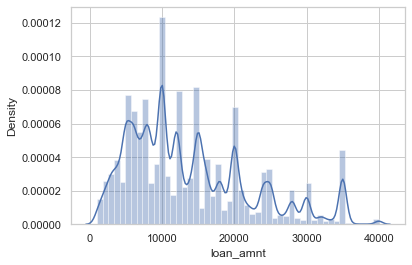

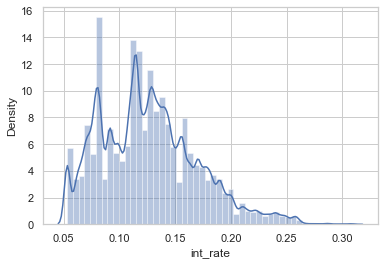

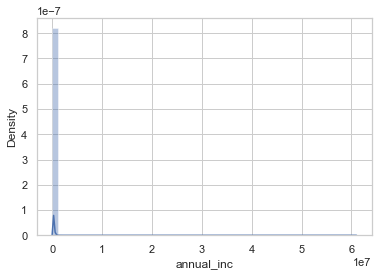

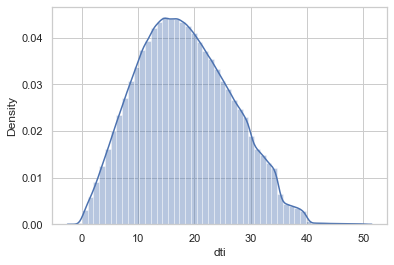

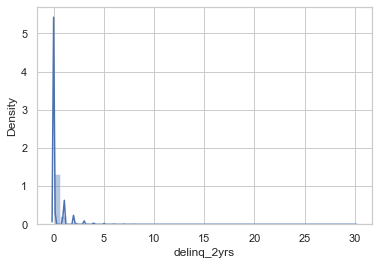

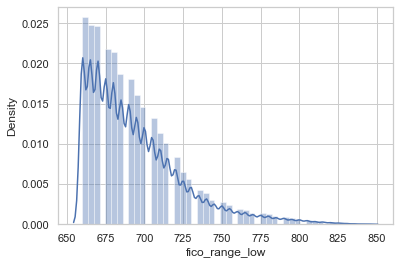

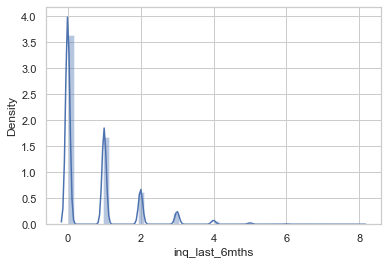

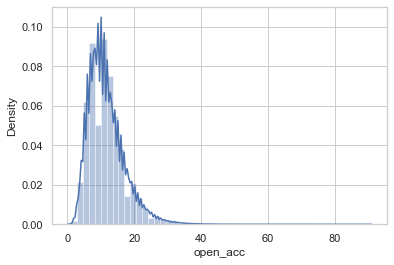

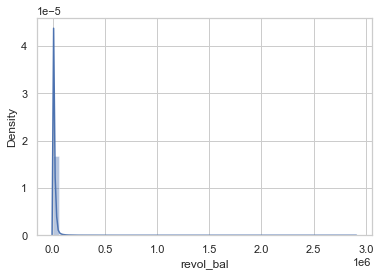

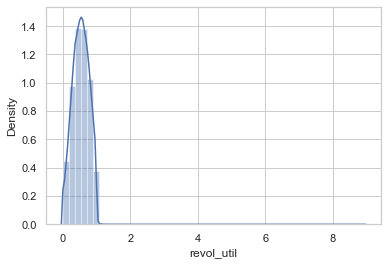

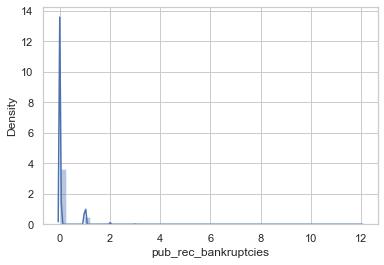

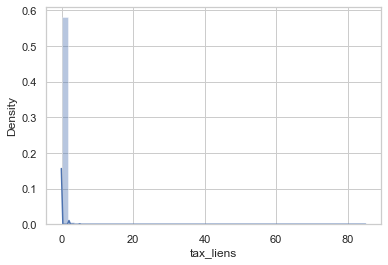

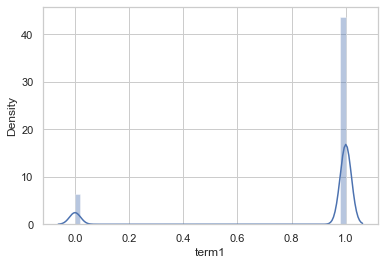

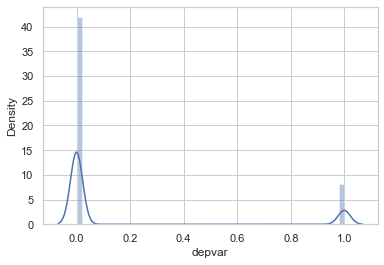

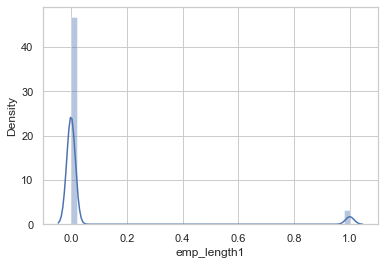

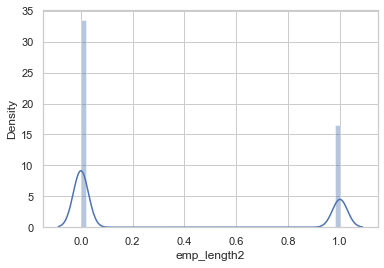

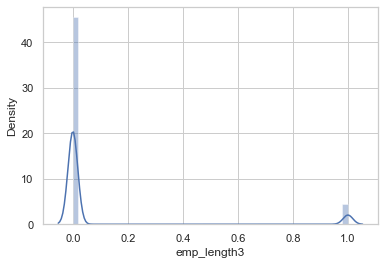

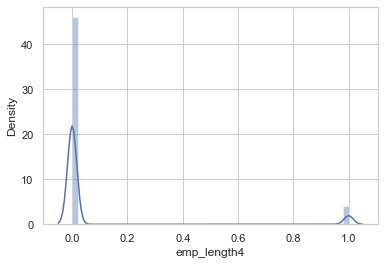

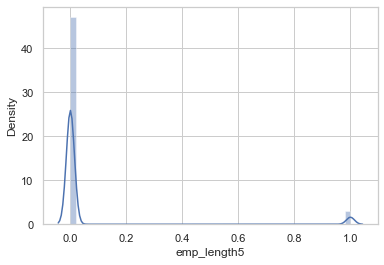

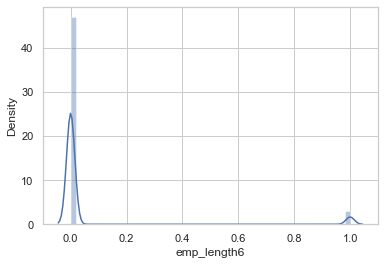

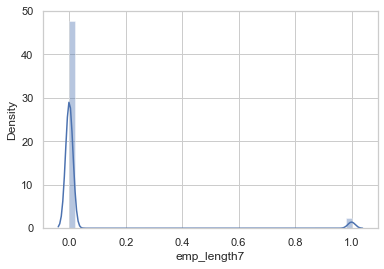

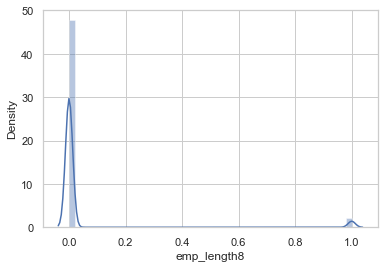

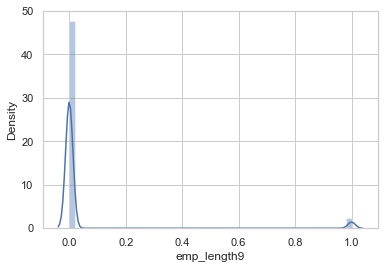

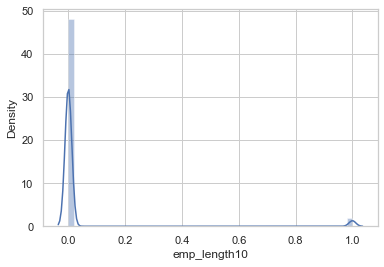

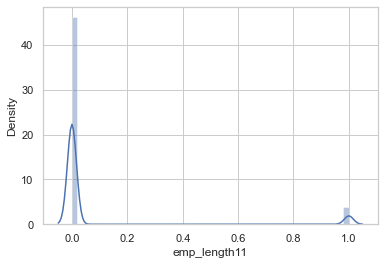

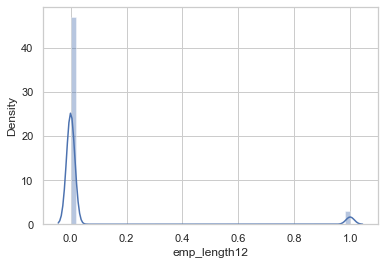

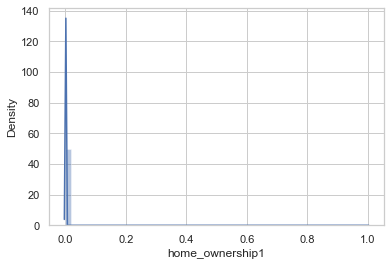

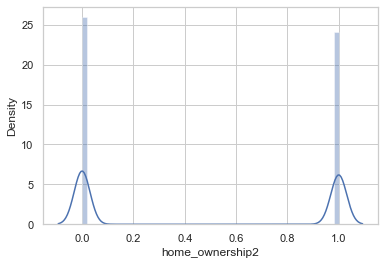

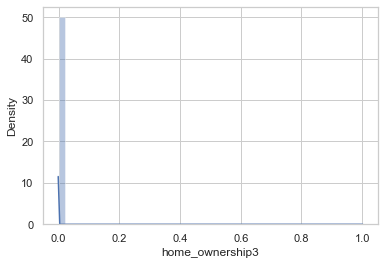

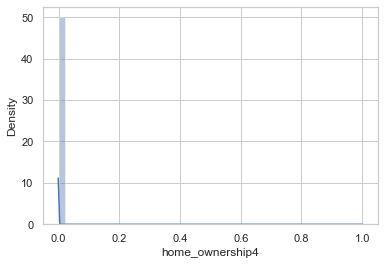

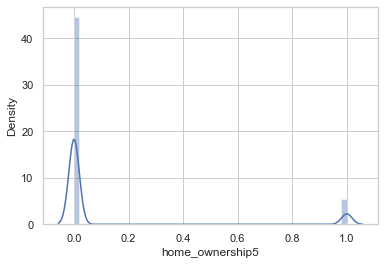

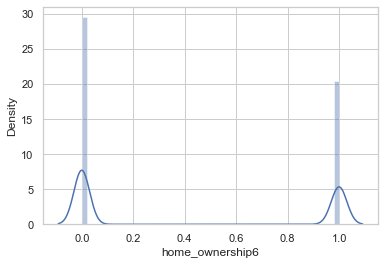

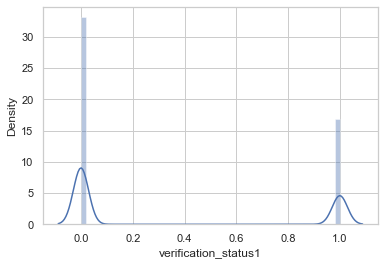

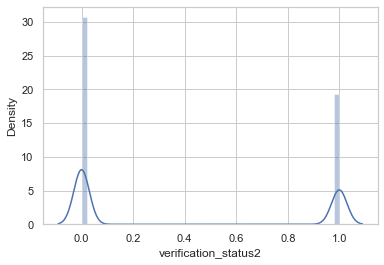

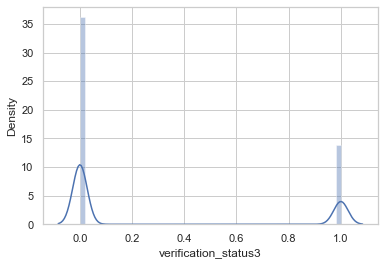

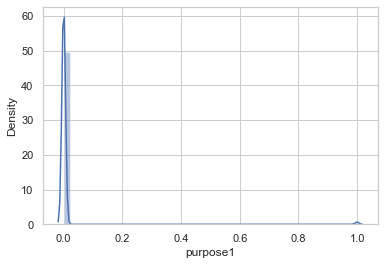

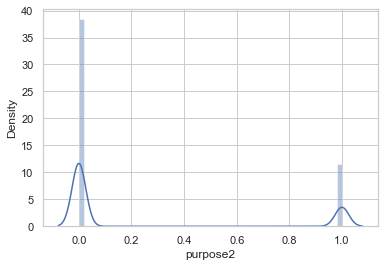

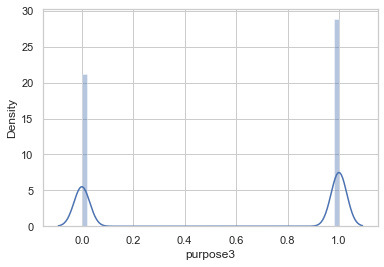

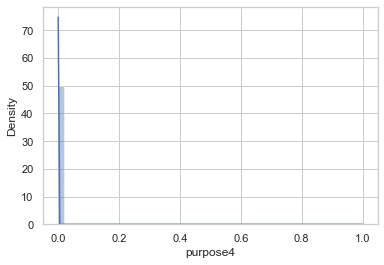

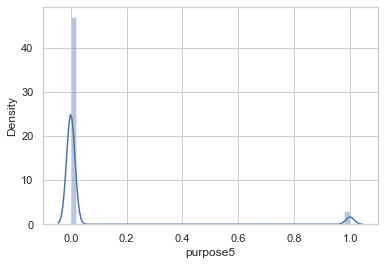

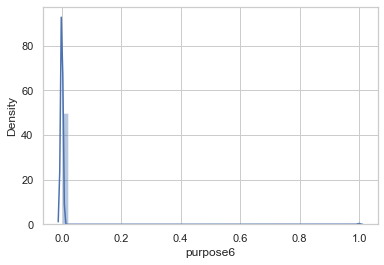

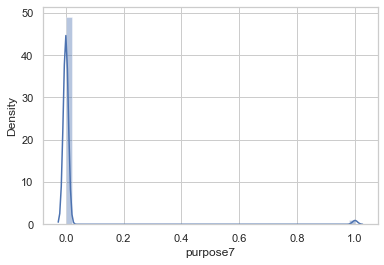

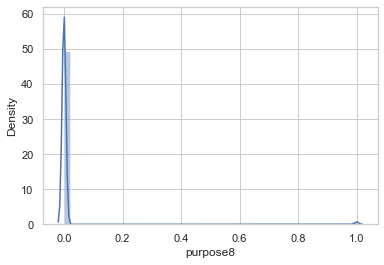

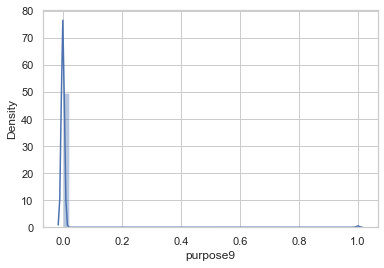

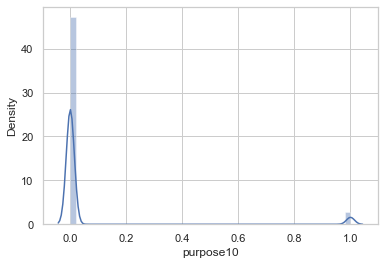

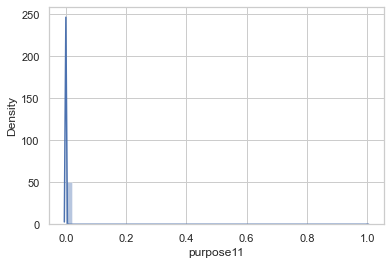

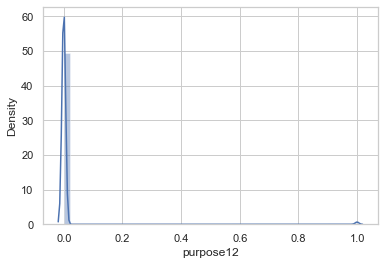

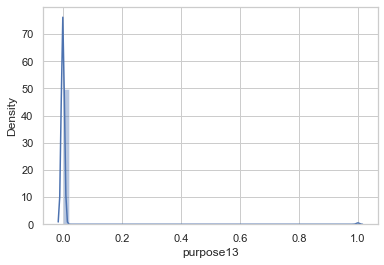

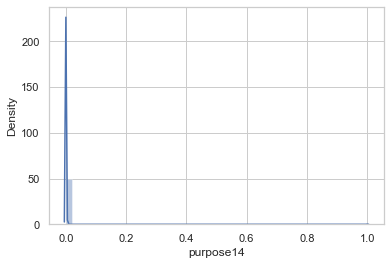

In [ ]:
#설명변수 분포 그림으로
cols = LC.columns

for col in cols:
    fig,ax = plt.subplots(1,1)
    sns.distplot(LC[col])

In [ ]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the depvar.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without depvar
    if continuous:
        sns.distplot(LC.loc[LC[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(LC[col_name], order=sorted(LC[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)
        
    plt.tight_layout()

## 2.2 설명변수 전처리

### 2.3.1 loan_amnt

In [ ]:
LC['loan_amnt'].describe()

count    1.092919e+06
mean     1.364630e+04
std      8.441163e+03
min      1.000000e+03
25%      7.125000e+03
50%      1.200000e+04
75%      1.900000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

<AxesSubplot:xlabel='loan_amnt', ylabel='Density'>

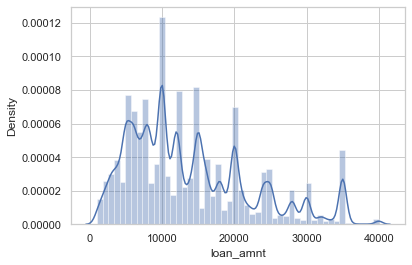

In [ ]:
sns.distplot(X['loan_amnt'])

In [ ]:
LC.groupby('depvar')['loan_amnt'].describe().T

depvar,0.0,1.0
count,916095.000000,176824.000000
mean,13554.392230,14122.470649
std,8427.131877,8497.606175
min,1000.000000,1000.000000
25%,7000.000000,7775.000000
50%,11700.000000,12000.000000
75%,18825.000000,20000.000000
max,40000.000000,40000.000000


### 2.3.2 int_rate

In [ ]:
LC['int_rate'].describe()

count    1.092919e+06
mean     1.263927e-01
std      4.361999e-02
min      5.320000e-02
25%      9.170000e-02
50%      1.229000e-01
75%      1.531000e-01
max      3.099000e-01
Name: int_rate, dtype: float64

<AxesSubplot:>

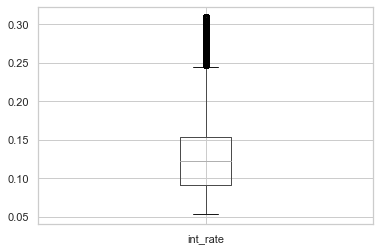

In [ ]:
LC.boxplot(column='int_rate')

<AxesSubplot:xlabel='int_rate', ylabel='Density'>

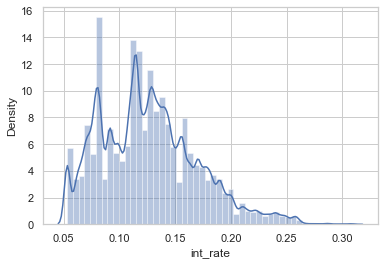

In [ ]:
sns.distplot(X['int_rate'])

In [ ]:
LC.groupby('depvar')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,0.122105,0.042173,0.0532,0.0890,0.1167,0.1465,0.3099
1.0,176824.0,0.148605,0.044240,0.0532,0.1153,0.1446,0.1757,0.3099


### 2.3.3 anual_inc

In [ ]:
import numpy as np

In [ ]:
#그래프 분포을 보았을 때, 매우 불균형한 분포를 보이기 때문에 로그변환을 시행
LC['log_annual_inc'] = LC['annual_inc'].apply(lambda x: np.log10(x+1))
LC.drop('annual_inc', axis=1, inplace=True)
LC['log_annual_inc'].describe()

count    1.092919e+06
mean     4.808911e+00
std      2.356236e-01
min      3.477266e+00
25%      4.653222e+00
50%      4.806187e+00
75%      4.954247e+00
max      7.785330e+00
Name: log_annual_inc, dtype: float64

<AxesSubplot:>

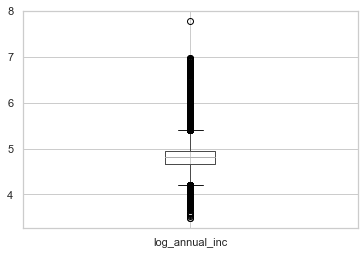

In [ ]:
LC.boxplot(column='log_annual_inc')

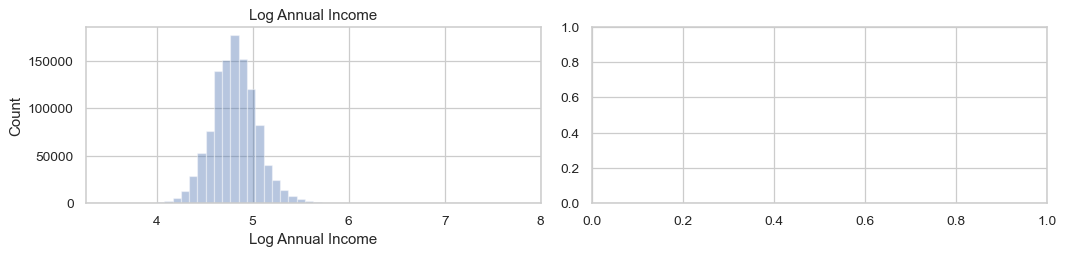

In [ ]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

In [ ]:
LC.groupby('depvar')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,4.816584,0.235748,3.477266,4.659197,4.812920,4.961288,7.785330
1.0,176824.0,4.769164,0.230932,3.602169,4.622382,4.773811,4.908490,6.981051


### 2.3.4 dti

In [ ]:
LC['dti'].describe()

count    1.092919e+06
mean     1.818105e+01
std      8.321510e+00
min     -1.000000e+00
25%      1.192000e+01
50%      1.768000e+01
75%      2.410000e+01
max      4.996000e+01
Name: dti, dtype: float64

<AxesSubplot:>

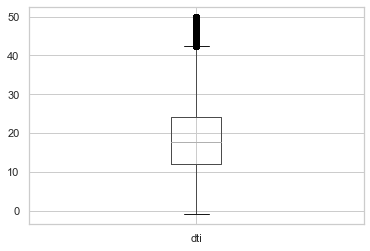

In [ ]:
LC.boxplot(column='dti')

<AxesSubplot:xlabel='dti', ylabel='Density'>

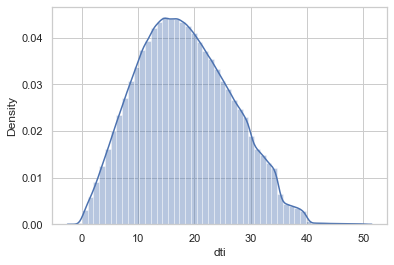

In [ ]:
sns.distplot(LC['dti'])

In [ ]:
LC.groupby('depvar')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,17.867036,8.253787,-1.0,11.65,17.31,23.69,49.96
1.0,176824.0,19.807906,8.479744,0.0,13.51,19.60,26.03,49.93


### 2.3.5 delinq_2yrs

In [ ]:
LC['delinq_2yrs'].describe()

count    1.092919e+06
mean     3.394543e-01
std      9.065449e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+01
Name: delinq_2yrs, dtype: float64

In [ ]:
LC['delinq_2yrs'].value_counts()

0     870371
1     146230
2      43888
3      16152
4       7342
5       3712
6       2082
7       1155
8        673
9        422
10       298
11       174
12       123
13        91
14        72
15        46
16        27
18        20
17        13
19        10
20         8
21         4
22         3
29         1
24         1
30         1
Name: delinq_2yrs, dtype: int64

<AxesSubplot:xlabel='delinq_2yrs', ylabel='Density'>

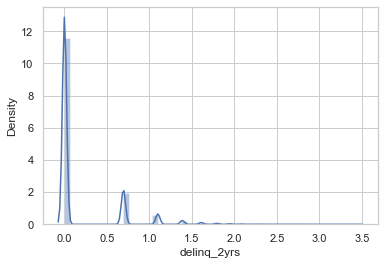

In [ ]:
# 그래프가 매우 불규칙적인 분포를 보여 로그변환을 취함
LC['delinq_2yrs'] = np.log1p(LC['delinq_2yrs'])
sns.distplot(LC['delinq_2yrs'])

In [ ]:
LC.groupby('depvar')['delinq_2yrs'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,NaN,0.000000,0.0,0.0,0.0,0.0,3.433594
1.0,176824.0,0.196167,0.411133,0.0,0.0,0.0,0.0,3.091797


### 2.3.6 fico_range_low

In [ ]:
LC[['fico_range_low']].describe()

,fico_range_low
count,1.092919e+06
mean,6.942867e+02
std,3.061425e+01
min,6.600000e+02
25%,6.700000e+02
50%,6.850000e+02
75%,7.100000e+02
max,8.450000e+02


<AxesSubplot:xlabel='fico_range_low', ylabel='Density'>

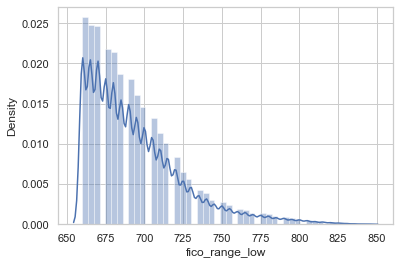

In [ ]:
sns.distplot(LC['fico_range_low'])

In [ ]:
LC['fico_range_low'].value_counts()

660    104087
665    100205
670     99716
675     88250
680     86408
685     75384
690     73105
695     65125
700     59040
705     53185
710     46134
715     40615
720     33681
725     26497
730     22748
735     17467
740     15551
745     12246
750     11198
755      9530
760      7742
765      7200
770      5892
775      5453
780      4975
785      4002
790      3634
795      2968
800      2701
805      2241
810      1657
815      1385
820      1006
825       763
830       502
835       297
840       186
845       143
Name: fico_range_low, dtype: int64

In [ ]:
LC.groupby('depvar')['fico_range_low'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,695.878326,31.422160,660.0,670.0,690.0,710.0,845.0
1.0,176824.0,686.040611,24.422386,660.0,670.0,680.0,700.0,845.0


### 2.3.7 inq_last_6mths

In [ ]:
LC['inq_last_6mths'].value_counts()

0    635739
1    293841
2    106988
3     39428
4     11918
5      4135
6       866
7         3
8         1
Name: inq_last_6mths, dtype: int64

<AxesSubplot:xlabel='inq_last_6mths', ylabel='Density'>

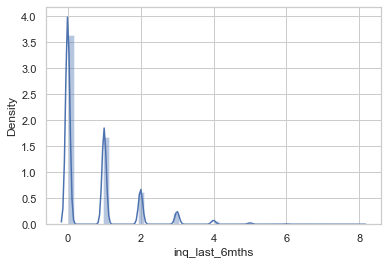

In [ ]:
sns.distplot(LC['inq_last_6mths'])

In [ ]:
LC.groupby('depvar')['inq_last_6mths'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,0.610252,0.911415,0.0,0.0,0.0,1.0,8.0
1.0,176824.0,0.795277,1.031453,0.0,0.0,0.0,1.0,6.0


### 2.3.8 open_acc

In [ ]:
LC['open_acc'].value_counts()

9     97854
10    95510
8     93907
11    87601
7     84428
12    78376
6     69749
13    68131
14    57899
5     50811
15    48547
16    40681
17    33551
4     29758
18    27700
19    22601
20    18087
21    14446
3     12252
22    11787
23     9404
24     7561
25     6008
26     4525
27     3665
2      3059
28     2860
29     2308
30     1880
31     1422
32     1233
33     1025
34      776
35      626
36      477
37      395
38      317
39      278
1       264
40      201
41      170
42      158
43      105
44       90
45       80
46       59
47       40
49       38
48       33
52       27
51       25
50       25
53       19
54       14
56       10
55        9
57        8
58        7
59        5
60        5
63        4
65        3
61        3
62        2
66        2
67        2
76        2
84        1
75        1
82        1
80        1
79        1
77        1
86        1
74        1
72        1
71        1
70        1
69        1
64        1
90        1
Name: open_acc, dtype: int64

<AxesSubplot:>

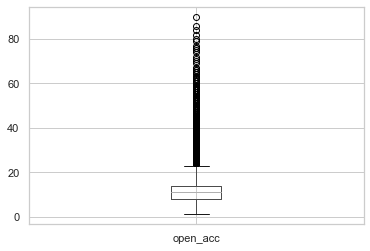

In [ ]:
LC.boxplot(column='open_acc')

<AxesSubplot:xlabel='open_acc', ylabel='Density'>

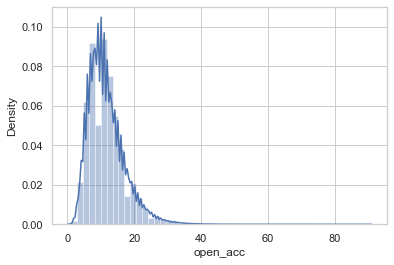

In [ ]:
sns.distplot(LC['open_acc'])

In [ ]:
LC.groupby('depvar')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,11.535759,5.411156,1.0,8.0,11.0,14.0,90.0
1.0,176824.0,11.806881,5.517532,1.0,8.0,11.0,15.0,76.0


### 2.3.9 revol_bal

In [ ]:
LC['revol_bal'].describe()

count    1.092919e+06
mean     1.633953e+04
std      2.264732e+04
min      0.000000e+00
25%      6.055000e+03
50%      1.113500e+04
75%      1.975600e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

<AxesSubplot:xlabel='revol_bal', ylabel='Density'>

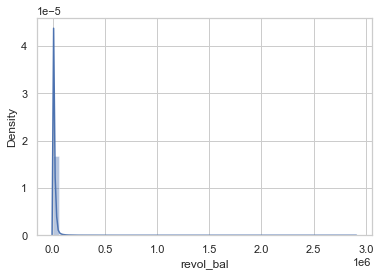

In [ ]:
sns.distplot(LC['revol_bal'])

In [ ]:
# 분포가 너무 한쪽으로 치우쳐져 로그변환을 취해줌
LC['log_revol_bal'] = LC['revol_bal'].apply(lambda x: np.log10(x+1))
LC.drop('revol_bal', axis=1, inplace=True)

<AxesSubplot:xlabel='log_revol_bal', ylabel='Density'>

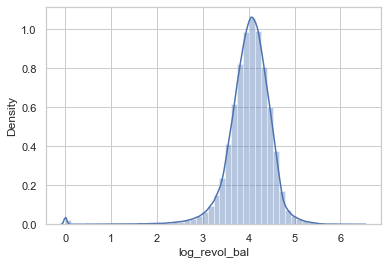

In [ ]:
sns.distplot(LC['log_revol_bal'])

<AxesSubplot:>

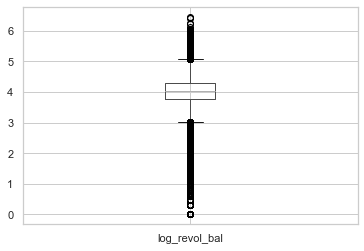

In [ ]:
LC.boxplot(column='log_revol_bal')

In [ ]:
LC.groupby('depvar')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,4.013909,0.487395,0.0,3.785187,4.050766,4.301854,6.463122
1.0,176824.0,3.984889,0.466796,0.0,3.767082,4.026370,4.264275,6.242223


### 2.3.10 revol_util

In [ ]:
LC['revol_util'].describe()

count    1.092919e+06
mean     5.311223e-01
std      2.389062e-01
min      0.000000e+00
25%      3.530000e-01
50%      5.350000e-01
75%      7.150000e-01
max      8.923000e+00
Name: revol_util, dtype: float64

<AxesSubplot:xlabel='revol_util', ylabel='Density'>

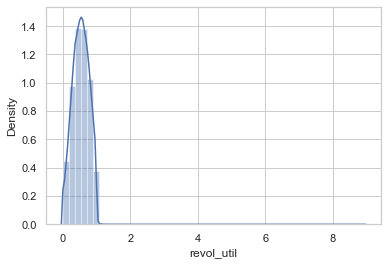

In [ ]:
sns.distplot(LC['revol_util'])

In [ ]:
LC.groupby('depvar')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,0.526324,0.239792,0.0,0.347,0.529,0.711,8.923
1.0,176824.0,0.555984,0.232683,0.0,0.387,0.562,0.734,3.666


### 2.3.11  pub_rec_bankruptcies

In [ ]:
LC['pub_rec_bankruptcies'].value_counts().sort_index()

0     959556
1     124395
2       6887
3       1498
4        373
5        140
6         42
7         17
8          8
9          1
11         1
12         1
Name: pub_rec_bankruptcies, dtype: int64

<AxesSubplot:xlabel='pub_rec_bankruptcies', ylabel='Density'>

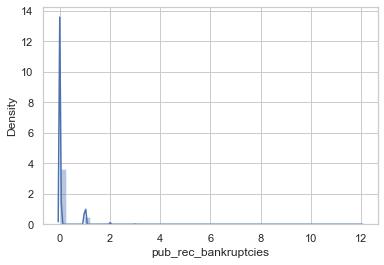

In [ ]:
sns.distplot(LC['pub_rec_bankruptcies'])

In [ ]:
LC.groupby('depvar')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,0.128625,0.374387,0.0,0.0,0.0,0.0,12.0
1.0,176824.0,0.155460,0.413691,0.0,0.0,0.0,0.0,11.0


### 2.3.12 tax_liens

In [ ]:
LC['tax_liens'].value_counts().sort_index()

0     1052420
1       27303
2        7588
3        2790
4        1260
5         684
6         366
7         180
8          93
9          65
10         48
11         31
12         19
13         11
14          8
15          9
16          6
17          7
18          4
19          1
20          2
21          4
22          2
23          1
24          2
27          3
30          1
34          1
37          1
39          1
45          1
46          1
48          1
53          1
61          2
63          1
85          1
Name: tax_liens, dtype: int64

<AxesSubplot:xlabel='tax_liens', ylabel='Density'>

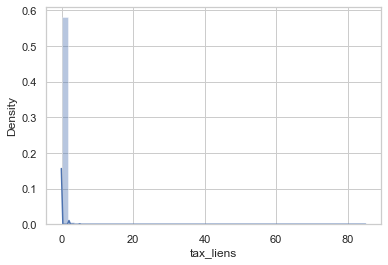

In [ ]:
sns.distplot(LC['tax_liens'])

In [ ]:
LC.groupby('depvar')['tax_liens'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
0.0,916095.0,0.059922,0.425294,0.0,0.0,0.0,0.0,63.0
1.0,176824.0,0.067112,0.508072,0.0,0.0,0.0,0.0,85.0


In [ ]:
# 원데이터 차원
df.shape

(1092919, 333)

In [ ]:
# 추려진 데이터 차원
LC.shape

(1092919, 49)

In [ ]:
# 독립변수 종속변수 구분
X = LC.drop('depvar',axis=1)
y = LC['depvar']

In [ ]:
LC.head()

,loan_amnt,int_rate,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,revol_util,pub_rec_bankruptcies,tax_liens,term1,depvar,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,log_annual_inc,log_revol_bal
0,19000,0.0916,16.36,0.693359,670,0,10,0.714,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.812920,4.027146
1,10000,0.0789,5.03,0.000000,690,1,5,0.684,0,0,1,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.763435,3.899875
2,6000,0.1147,24.23,1.098633,665,1,9,0.257,0,0,1,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4.671182,3.619302
3,25200,0.1199,32.87,0.000000,685,0,5,0.566,1,0,1,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4.882416,3.889638
4,8000,0.1299,20.28,0.000000,770,1,12,0.160,0,0,1,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4.462413,3.801061


In [ ]:
LC = LC[['depvar','loan_amnt', 'int_rate', 'log_annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'inq_last_6mths',
        'open_acc', 'log_revol_bal', 'revol_util', 'pub_rec_bankruptcies',
       'tax_liens', 'emp_length1', 'emp_length2', 'emp_length3', 'emp_length4', 'emp_length5', 'emp_length6', 'emp_length7',
       'emp_length8', 'emp_length9', 'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1', 'home_ownership2',
       'home_ownership3', 'home_ownership4', 'home_ownership5', 'home_ownership6', 'verification_status1', 
        'verification_status2', 'verification_status3', 'purpose1', 'purpose2', 'purpose3','purpose4', 'purpose5',
          'purpose6','purpose7', 'purpose8', 'purpose9', 'purpose10', 'purpose11', 'purpose12', 'purpose13', 'purpose14', 'term1']]

In [ ]:
# 전처리까지 완료한 최종데이터 (더미변수는 이미 전처리가 되었기 때문에 전처리 설명에서 제외)
LC.head()

,depvar,loan_amnt,int_rate,log_annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,log_revol_bal,revol_util,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,term1
0,0.0,19000,0.0916,4.812920,16.36,0.693359,670,0,10,4.027146,0.714,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,10000,0.0789,4.763435,5.03,0.000000,690,1,5,3.899875,0.684,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,6000,0.1147,4.671182,24.23,1.098633,665,1,9,3.619302,0.257,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1.0,25200,0.1199,4.882416,32.87,0.000000,685,0,5,3.889638,0.566,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,8000,0.1299,4.462413,20.28,0.000000,770,1,12,3.801061,0.160,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1


# 3. Statistics for Modeling

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#원본데이터 복사
LC_1=LC.copy() 

In [ ]:
# 데이터를 train, validation, test set을 6:2:2로 나눔
train, validation, test = np.split(LC_1.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [ ]:
train.shape

(655751, 49)

In [ ]:
validation.shape    

(218584, 49)

In [ ]:
test.shape

(218584, 49)

<AxesSubplot:>

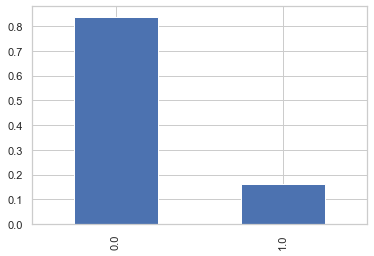

In [ ]:
#히스토그램으로 원데이터, train, validation, test set의 'depvar = 1의 비율 비교하기'
(LC_1.depvar.value_counts()/len(LC_1)).plot(kind='bar')

<AxesSubplot:>

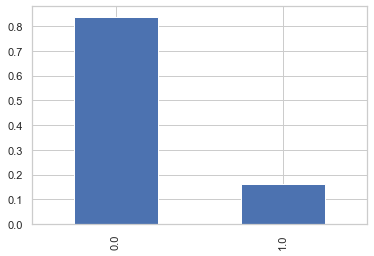

In [ ]:
(train.depvar.value_counts()/len(train)).plot(kind='bar')

<AxesSubplot:>

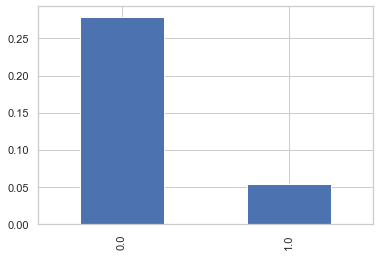

In [ ]:
(validation.depvar.value_counts()/len(train)).plot(kind='bar')

<AxesSubplot:>

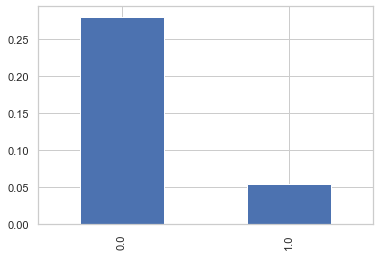

In [ ]:
(test.depvar.value_counts()/len(train)).plot(kind='bar')

In [ ]:
#traini, validation, test set 데이터를 독립변수와 종속변수로 구분
X = LC_1.drop('depvar',axis=1)
y = LC_1['depvar']
y_train = train['depvar']
X_train = train.drop('depvar',axis=1)
y_validation = validation['depvar']
X_validation = validation.drop('depvar',axis=1)
y_test = test['depvar']
X_test = test.drop('depvar',axis=1)

In [ ]:
# 종속변수들의 스케일 조정을 위해 종속변수를 일반변수와 더미변수로 구분
x_dummy_cols = ['emp_length1','emp_length2', 'emp_length3', 'emp_length4', 'emp_length5','emp_length6', 'emp_length7', 'emp_length8', 'emp_length9',
       'emp_length10', 'emp_length11', 'emp_length12', 'home_ownership1','home_ownership2', 'home_ownership3', 'home_ownership4',
       'home_ownership5', 'home_ownership6', 'verification_status1','verification_status2', 'verification_status3', 'purpose1',
        'purpose2','purpose3', 'purpose4', 'purpose5', 'purpose6', 'purpose7', 'purpose8','purpose9', 'purpose10', 'purpose11',
        'purpose12', 'purpose13','purpose14', 'term1']
x_cols = ['loan_amnt', 'int_rate', 'log_annual_inc', 'dti', 'delinq_2yrs','inq_last_6mths', 'open_acc', 'log_revol_bal', 'revol_util',
       'pub_rec_bankruptcies', 'tax_liens','fico_range_low']
y_col = ['depvar']

In [ ]:
# 더미변수(명목형 변수)를 제외한 설명변수(연속형, 순서형 변수)들을 대상으로 Standard Scaling 실시
def scaler(df, opt='standard'):
    if opt=='standard':
        scale = StandardScaler()
    elif opt=='minmax':
        scale = StandardScaler()    
    scale.fit(df)
    return scale.transform(df)

X_train[x_cols] = scaler(X_train[x_cols], opt='standard')
X_validation[x_cols] = scaler(X_validation[x_cols], opt='standard')
X_test[x_cols] = scaler(X_test[x_cols], opt='standard')

In [ ]:
# 이거 남겨놓기
#LC_1 = LC.copy()
#LC_1['depvar'] = LC_1['depvar'].astype('float64')

In [ ]:
# 종속변수의 분포가 불균형적이기 때문에 Train set을 SMOTE를 통해 Oversampling
from imblearn.over_sampling import SMOTE 
sm= SMOTE(random_state=156)
X_sm, y_sm = sm.fit_sample(X_train, y_train)
X_sm_val, y_sm_val = sm.fit_sample(X_validation, y_validation)

print('SMOTE 적용 전 학습용 피처/레이블 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 세트: ', X_sm.shape, y_sm.shape)
print('SMOTE 적용 후 train set 레이블 값 분포: \n',pd.Series(y_sm).value_counts())

print('SMOTE 적용 전 검증용 피처/레이블 세트: ', X_validation.shape, y_validation.shape)
print('SMOTE 적용 후 검증용 피처/레이블 세트: ', X_sm_val.shape, y_sm_val.shape)
print('SMOTE 적용 후 validation set 레이블 값 분포: \n',pd.Series(y_sm_val).value_counts())

SMOTE 적용 전 학습용 피처/레이블 세트:  (655751, 48) (655751,)
SMOTE 적용 후 학습용 피처/레이블 세트:  (1099326, 48) (1099326,)
SMOTE 적용 후 train set 레이블 값 분포: 
 1.0    549663
0.0    549663
Name: depvar, dtype: int64
SMOTE 적용 전 검증용 피처/레이블 세트:  (218584, 48) (218584,)
SMOTE 적용 후 검증용 피처/레이블 세트:  (366048, 48) (366048,)
SMOTE 적용 후 validation set 레이블 값 분포: 
 0.0    183024
1.0    183024
Name: depvar, dtype: int64


In [ ]:
# Train set과 Validation set 합친 것
trval = pd.concat([train,validation])
X_trval = pd.concat([X_train,X_validation])
y_trval = pd.concat([y_train,y_validation])
X_sm_trval = pd.concat([X_sm,X_sm_val])
y_sm_trval = pd.concat([y_sm,y_sm_val])

## 3.1 Logistic Regression (SMOTE 적용)

In [ ]:
lr_sm = LogisticRegression() 
lr_sm.fit(X_sm, y_sm)

LogisticRegression()

In [ ]:
# 변수들의 계수 확인
print(lr_sm.intercept_)
print(lr_sm.coef_) 

[24.30408558]
[[ 9.67114662e-02  3.43668261e-01 -2.10077588e-01  1.48183463e-01
  -1.28191872e-01 -3.83355548e-01 -6.61583733e-03  1.22374071e-02
  -1.09360310e-02 -3.41856432e-02 -1.17524392e-01 -1.22894018e-01
  -9.26060178e+00 -8.91666922e+00 -9.24442780e+00 -9.21088799e+00
  -9.35423727e+00 -9.28416277e+00 -9.36341787e+00 -9.38528879e+00
  -9.29686257e+00 -9.30304929e+00 -9.22383197e+00 -8.68939178e+00
  -3.54193872e+00 -4.93734969e+00 -3.20378848e-01 -3.79220490e-01
  -5.19823843e+00 -4.60616437e+00 -5.85509644e+00 -5.73807958e+00
  -5.88910021e+00 -5.70621035e+00 -4.86025586e+00 -4.60326400e+00
   0.00000000e+00 -5.03964366e+00 -5.91605565e+00 -5.46968888e+00
  -5.37651088e+00 -5.36047836e+00 -5.23636195e+00 -5.51155846e+00
  -5.09354200e+00 -5.24165143e+00 -6.48931390e+00 -5.43936717e-01]]


In [ ]:
# 계수를 이용한 predicted probability 계산하기
lr_sm.predict_proba(X_sm)[:,1]

array([0.56032232, 0.48957701, 0.49979938, ..., 0.99994289, 0.35006472,
       0.98909923])

In [ ]:
val_sm = pd.DataFrame(lr_sm.predict_proba(X_validation)[:,1], columns=['lr_sm_pred_prob'])

<AxesSubplot:ylabel='Frequency'>

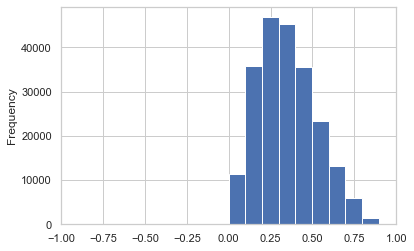

In [ ]:
# predicted probability 분포
val_sm.lr_sm_pred_prob.plot(kind='hist',bins=10, xlim=([-1,1]))

In [ ]:
# FPR, TPR, Threshold 설정
fpr_lr_sm,tpr_lr_sm,thresholds_lr_sm = roc_curve(validation.depvar, val_sm.lr_sm_pred_prob)

In [ ]:
# auc 구하기
roc_auc_lr_sm = auc(fpr_lr_sm, tpr_lr_sm)
roc_auc_lr_sm

0.6593744439436711

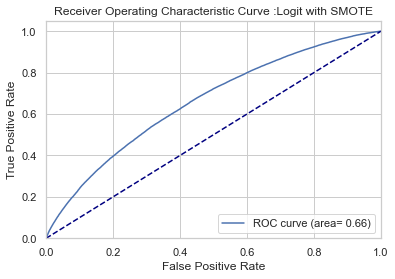

In [ ]:
# AUROC 그리기

plt.figure()
plt.plot(fpr_lr_sm, tpr_lr_sm, label='ROC curve (area= %0.2f)' % roc_auc_lr_sm)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit with SMOTE')
plt.legend(loc="lower right")

plt.show()

In [ ]:
#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result_lr_sm = pd.DataFrame([fpr_lr_sm,tpr_lr_sm,thresholds_lr_sm], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result_lr_sm['best'] = (1-roc_result_lr_sm.fpr)+(roc_result_lr_sm.tpr)
roc_result_lr_sm.tail()

,fpr,tpr,thresholds,best
56714,0.999661,0.999944,1.500284e-02,1.000283
56715,0.999661,0.999972,1.489588e-02,1.000311
56716,0.999962,0.999972,6.563729e-03,1.000010
56717,0.999962,1.000000,4.293385e-03,1.000038
56718,1.000000,1.000000,1.561535e-08,1.000000


In [ ]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold_lr_sm=roc_result_lr_sm.thresholds[roc_result_lr_sm.best.idxmax()] 
optimal_threshold_lr_sm

0.3451450577399087

In [ ]:
# test set의 부도 확률을 predict 하기
result = pd.DataFrame(lr_sm.predict_proba(X_test)[:,1], columns=['lr_sm_pred_prob'])

<AxesSubplot:ylabel='Frequency'>

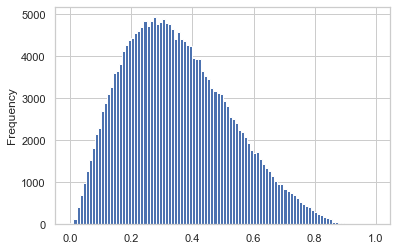

In [ ]:
#test set의 predicted Probability의 분포 확인하기
result.lr_sm_pred_prob.plot(kind='hist', bins=100)

In [ ]:
# optimal threshold를 이용하여 binary (0 or 1) 로 예측
result['lr_sm_binary']=np.where(result.lr_sm_pred_prob>=optimal_threshold_lr_sm,1,0)

In [ ]:
lr_sm_con = confusion_matrix(y_test, result.lr_sm_binary)
lr_sm_con

array([[104048,  79360],
       [ 11915,  23261]], dtype=int64)

In [ ]:
tn_1, fp_1, fn_1, tp_1 = confusion_matrix(y_test, result.lr_sm_binary).ravel()
(tn_1, fp_1, fn_1, tp_1)

(104048, 79360, 11915, 23261)

In [ ]:
recall_1 = tp_1/(tp_1+fn_1)
recall_1

0.6612747327723448

In [ ]:
precision_1 = tp_1/(tp_1+fp_1)
precision_1

0.2266690053692714

In [ ]:
f1_score_1 = ((recall_1*precision_1)/(recall_1+precision_1)*2)
f1_score_1

0.3376125750197755

In [ ]:
lr_sm_score = classification_report(y_test,result.lr_sm_binary)
print(lr_sm_score)

              precision    recall  f1-score   support

         0.0       0.90      0.57      0.70    183408
         1.0       0.23      0.66      0.34     35176

    accuracy                           0.58    218584
   macro avg       0.56      0.61      0.52    218584
weighted avg       0.79      0.58      0.64    218584



In [ ]:
# model score
score_lr_sm = 1/((0.8*1/recall_1)+(0.2*1/precision_1))
score_lr_sm

0.47798212267543405

## 3.2 Logistic Regression (SMOTE 미적용)

In [ ]:
lr = LogisticRegression() 
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# 변수들의 계수 확인
print(lr.intercept_)
print(lr.coef_) 

[-0.90706024]
[[ 0.13601626  0.40235088 -0.11996927  0.13480277  0.00389066 -0.20927575
   0.06874491  0.07486708 -0.08176627 -0.0149503   0.00325808  0.00778242
  -0.10841265 -0.13642713 -0.12463956 -0.11146676 -0.12809344 -0.10022832
  -0.09783792 -0.11082029 -0.0607746  -0.08532113 -0.10485049  0.28834341
  -0.20252377 -0.33744962 -0.03566174 -0.03320921 -0.21529226 -0.05639227
  -0.34799669 -0.21712318 -0.315409   -0.1338391  -0.10405464 -0.0442224
   0.         -0.00454831 -0.13487819 -0.05788571  0.04948405 -0.08574212
  -0.10797914 -0.03575634  0.18611035  0.01743409 -0.4246514  -0.28392458]]


In [ ]:
# 계수를 이용한 predicted probability 계산하기
lr.predict_proba(X_train)[:,1]

array([0.23172626, 0.23036998, 0.26130378, ..., 0.12875002, 0.12772489,
       0.06875491])

In [ ]:
# Logistic Regression 결과를 validation set에 predict
val_lr = pd.DataFrame(lr.predict_proba(X_validation)[:,1], columns=['lr_pred_prob'])

<AxesSubplot:ylabel='Frequency'>

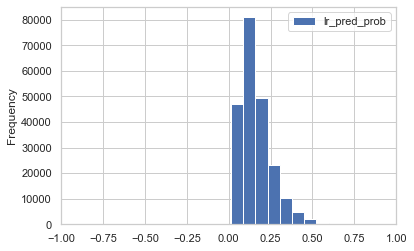

In [ ]:
val_lr.plot(kind='hist',bins=10, xlim=([-1,1]))

In [ ]:
# FPR, TPR, Threshold 설정
fpr_lr,tpr_lr,thresholds_lr = roc_curve(validation.depvar, val_lr.lr_pred_prob)

In [ ]:
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.6896763828068402

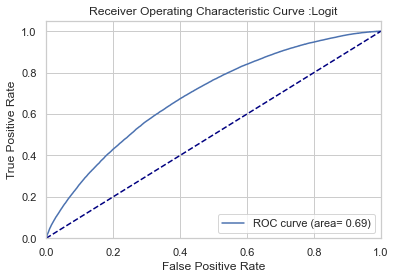

In [ ]:
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='ROC curve (area= %0.2f)' % roc_auc_lr)

##그래프에 직선 추가하기
plt.plot([0,1],[0,1],color='navy', linestyle='--')

#x축과 y축 구간 설정하기
plt.xlim([0,1])
plt.ylim([0,1.05])

#축 이름 및 그래프 타이틀, 레전드 추가하기
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve :Logit')
plt.legend(loc="lower right")

plt.show()

In [ ]:
#fpr, tpr, threshold 로 구성된 dataframe 생성하기
roc_result_lr = pd.DataFrame([fpr_lr,tpr_lr,thresholds_lr], index=['fpr','tpr','thresholds']).T
# (1-fpr)+(tpr)값을 계산하여 'best'라는 이름의 칼럼 생성하기
roc_result_lr['best'] = (1-roc_result_lr.fpr)+(roc_result_lr.tpr) 
roc_result_lr.tail(20)

,fpr,tpr,thresholds,best
55663,0.995088,0.999747,0.027713,1.004659
55664,0.995165,0.999747,0.027625,1.004582
55665,0.995165,0.999775,0.027625,1.004610
55666,0.995427,0.999775,0.027296,1.004348
55667,0.995427,0.999803,0.027295,1.004376
55668,0.996798,0.999803,0.025743,1.003005
55669,0.996798,0.999831,0.025736,1.003033
55670,0.996935,0.999831,0.025544,1.002896
55671,0.996935,0.999859,0.025539,1.002925
55672,0.997224,0.999859,0.025159,1.002635


In [ ]:
#최적 threshold는 best의 값이 최대가 될 때의 threshold 값
optimal_threshold_lr=roc_result_lr.thresholds[roc_result_lr.best.idxmax()] 
#best의 값이 최대가 될 때의 threshold
optimal_threshold_lr

0.15310814419829585

In [ ]:
# training set에서 계산한 coefficient를 이용하여 test set의 부도 확률을 predict 하기
result = pd.DataFrame(lr.predict_proba(X_test)[:,1], columns=['lr_pred_prob'])

<AxesSubplot:ylabel='Frequency'>

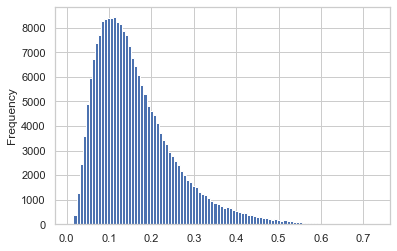

In [ ]:
#test set의 predicted Probability의 분포 확인하기
result.lr_pred_prob.plot(kind='hist', bins=100)

In [ ]:
# optimal threshold를 이용하여 binary (0 or 1) 로 예측
result['lr_binary']=np.where(result.lr_pred_prob>=optimal_threshold_lr,1,0)

In [ ]:
lr_con = confusion_matrix(y_test, result.lr_binary)
lr_con

array([[110553,  72855],
       [ 11348,  23828]], dtype=int64)

In [ ]:
tn_2, fp_2, fn_2, tp_2 = confusion_matrix(y_test, result.lr_binary).ravel()
(tn_2, fp_2, fn_2, tp_2)

(110553, 72855, 11348, 23828)

In [ ]:
recall_2 = tp_2/(tp_2+fn_2)
recall_2

0.6773936775073914

In [ ]:
precision_2 = tp_2/(tp_2+fp_2)
precision_2

0.24645490934290412

In [ ]:
f1_score_2 = ((recall_2*precision_2)/(recall_2+precision_2)*2)
f1_score_2

0.3614163614163614

In [ ]:
lr_score = classification_report(y_test,result.lr_binary)
print(lr_score)

              precision    recall  f1-score   support

         0.0       0.91      0.60      0.72    183408
         1.0       0.25      0.68      0.36     35176

    accuracy                           0.61    218584
   macro avg       0.58      0.64      0.54    218584
weighted avg       0.80      0.61      0.67    218584



In [ ]:
# model score
score_lr = 1/((0.8*1/recall_2)+(0.2*1/precision_2))
score_lr

0.5018808949099993

## 3.3 Decision Tree(SMOTE 적용)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn import tree
from os import system   

In [ ]:
!pip install graphviz

In [ ]:
dt_sm = DecisionTreeClassifier(random_state=156)
dt_sm.fit(X_sm,y_sm)
val_dt_sm = dt_sm.predict(X_validation)

In [ ]:
dt_sm_score_val=classification_report(y_validation,val_dt_sm)
print(dt_sm_score_val)

              precision    recall  f1-score   support

         0.0       0.81      0.00      0.00    183024
         1.0       0.16      1.00      0.28     35560

    accuracy                           0.16    218584
   macro avg       0.48      0.50      0.14    218584
weighted avg       0.70      0.16      0.05    218584



In [ ]:
# default로 했을 시 model score
score_dt_sm_val = 1/(0.8*(1/1.00)+0.2*(1/0.16))
score_dt_sm_val

0.48780487804878053

In [ ]:
# 'depvar =1'에 대한 recall 값이 지나치게 높아 decision tree의 'max depth'를 2로 제한
dt_sm1 = DecisionTreeClassifier(random_state=156, max_depth=2)
dt_sm1.fit(X_sm,y_sm)
val_dt_sm1 = dt_sm1.predict(X_validation)

In [ ]:
dt_sm1_score_val=classification_report(y_validation,val_dt_sm1)
print(dt_sm1_score_val)

              precision    recall  f1-score   support

         0.0       0.91      0.49      0.64    183024
         1.0       0.22      0.75      0.34     35560

    accuracy                           0.53    218584
   macro avg       0.57      0.62      0.49    218584
weighted avg       0.80      0.53      0.59    218584



In [ ]:
# max_depth =2로 했을 시 model score
score_dt_sm_val1 = 1/(0.8*(1/0.75)+0.2*(1/0.22))
score_dt_sm_val1

0.5061349693251533

In [ ]:
# decision tree의 'max depth'를 4로 제한
dt_sm2 = DecisionTreeClassifier(random_state=156, max_depth=4)
dt_sm2.fit(X_sm,y_sm)
val_dt_sm2 = dt_sm2.predict(X_validation)
dt_sm2_score_val=classification_report(y_validation,val_dt_sm2)
print(dt_sm2_score_val)

              precision    recall  f1-score   support

         0.0       0.91      0.47      0.62    183024
         1.0       0.22      0.76      0.34     35560

    accuracy                           0.52    218584
   macro avg       0.56      0.61      0.48    218584
weighted avg       0.80      0.52      0.58    218584



In [ ]:
# max_depth =4로 했을 시 model score
score_dt_sm_val2 = 1/(0.8*(1/0.76)+0.2*(1/0.22))
score_dt_sm_val2

0.5097560975609755

In [ ]:
# decision tree의 'max depth'를 6로 제한
dt_sm3 = DecisionTreeClassifier(random_state=156, max_depth=6)
dt_sm3.fit(X_sm,y_sm)
val_dt_sm3 = dt_sm3.predict(X_validation)
dt_sm3_score_val=classification_report(y_validation,val_dt_sm3)
print(dt_sm3_score_val)

              precision    recall  f1-score   support

         0.0       0.90      0.42      0.58    183024
         1.0       0.20      0.76      0.32     35560

    accuracy                           0.48    218584
   macro avg       0.55      0.59      0.45    218584
weighted avg       0.79      0.48      0.53    218584



In [ ]:
# max_depth =6로 했을 시 model score
score_dt_sm_val3 = 1/(0.8*(1/0.76)+0.2*(1/0.20))
score_dt_sm_val3

0.4871794871794871

In [ ]:
# decision tree의 'max depth'를 8로 제한
dt_sm4 = DecisionTreeClassifier(random_state=156, max_depth=8)
dt_sm4.fit(X_sm,y_sm)
val_dt_sm4 = dt_sm4.predict(X_validation)
dt_sm4_score_val=classification_report(y_validation,val_dt_sm4)
print(dt_sm4_score_val)

              precision    recall  f1-score   support

         0.0       0.91      0.33      0.48    183024
         1.0       0.19      0.83      0.31     35560

    accuracy                           0.41    218584
   macro avg       0.55      0.58      0.40    218584
weighted avg       0.79      0.41      0.45    218584



In [ ]:
# max_depth =8로 했을 시 model score
score_dt_sm_val4 = 1/(0.8*(1/0.83)+0.2*(1/0.19))
score_dt_sm_val4

0.49591194968553454

max depth가 2와 4일 때 recall값과 model score가 유사한 값을 보이다가 8이 되면서 다시 떨어지기 시작, max depth = 4의 모델을 최적으로 선정

In [ ]:
result_dt_sm = dt_sm2.predict(X_test)
dt_sm_score = classification_report(y_test,result_dt_sm)
print(dt_sm_score)

              precision    recall  f1-score   support

         0.0       0.91      0.46      0.61    183408
         1.0       0.21      0.76      0.33     35176

    accuracy                           0.51    218584
   macro avg       0.56      0.61      0.47    218584
weighted avg       0.80      0.51      0.57    218584



In [ ]:
score_dt_sm = 1/((0.8*1/0.76)+(0.2*1/0.21))
score_dt_sm

0.49875

## 3.4 Decision Tree(SMOTE 미적용)

In [ ]:
dt = DecisionTreeClassifier(random_state=156)
dt.fit(X_train,y_train)
val_dt = dt.predict(X_validation)

In [ ]:
dt_score_val=classification_report(y_validation,val_dt)
print(dt_score_val)

              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84    183024
         1.0       0.21      0.24      0.22     35560

    accuracy                           0.73    218584
   macro avg       0.53      0.53      0.53    218584
weighted avg       0.75      0.73      0.74    218584



In [ ]:
# decision tree의 'max depth'를 2로 제한
dt1 = DecisionTreeClassifier(random_state=156, max_depth=2)
dt1.fit(X_train,y_train)
val_dt1 = dt1.predict(X_validation)
dt1_score_val=classification_report(y_validation,val_dt1)
print(dt1_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# decision tree의 'max depth'를 4로 제한
dt2 = DecisionTreeClassifier(random_state=156, max_depth=4)
dt2.fit(X_train,y_train)
val_dt2 = dt2.predict(X_validation)
dt2_score_val=classification_report(y_validation,val_dt2)
print(dt2_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# decision tree의 'max depth'를 6로 제한
dt3 = DecisionTreeClassifier(random_state=156, max_depth=6)
dt3.fit(X_train,y_train)
val_dt3 = dt3.predict(X_validation)
dt3_score_val=classification_report(y_validation,val_dt3)
print(dt3_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.36      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.60      0.50      0.46    218584
weighted avg       0.76      0.84      0.76    218584



In [ ]:
# decision tree의 'max depth'를 8로 제한
dt4 = DecisionTreeClassifier(random_state=156, max_depth=8)
dt4.fit(X_train,y_train)
val_dt4 = dt4.predict(X_validation)
dt4_score_val=classification_report(y_validation,val_dt4)
print(dt4_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.44      0.01      0.01     35560

    accuracy                           0.84    218584
   macro avg       0.64      0.50      0.46    218584
weighted avg       0.77      0.84      0.76    218584



In [ ]:
# decision tree의 'max depth'를 16로 제한
dt5 = DecisionTreeClassifier(random_state=156, max_depth=16)
dt5.fit(X_train,y_train)
val_dt5 = dt5.predict(X_validation)
dt5_score_val=classification_report(y_validation,val_dt5)
print(dt5_score_val)

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90    183024
         1.0       0.26      0.05      0.09     35560

    accuracy                           0.82    218584
   macro avg       0.55      0.51      0.49    218584
weighted avg       0.75      0.82      0.77    218584



In [ ]:
# decision tree의 'max depth'를 24로 제한
dt6 = DecisionTreeClassifier(random_state=156, max_depth=24)
dt6.fit(X_train,y_train)
val_dt6 = dt6.predict(X_validation)
dt6_score_val=classification_report(y_validation,val_dt6)
print(dt6_score_val)

              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87    183024
         1.0       0.23      0.16      0.19     35560

    accuracy                           0.78    218584
   macro avg       0.54      0.53      0.53    218584
weighted avg       0.75      0.78      0.76    218584



SMOTE를 적용하지 않은 Decision Tree Model은 Max depth를 계속 올려도 recall값과 f1 score가 유의미한 값까지 오르지 못하고 있음.
모델 기각

## 3.5 Random Forest(SMOTE 적용)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_sm = RandomForestClassifier(random_state=156)
rf_sm.fit(X_sm,y_sm)
val_rf_sm = rf_sm.predict(X_validation)
rf_sm_score_val = classification_report(y_validation,val_rf_sm)
print(rf_sm_score_val)

              precision    recall  f1-score   support

         0.0       0.88      0.34      0.49    183024
         1.0       0.18      0.77      0.30     35560

    accuracy                           0.41    218584
   macro avg       0.53      0.55      0.39    218584
weighted avg       0.77      0.41      0.46    218584



In [ ]:
# default로 했을 시 model score
score_rf_sm_val = 1/(0.8*(1/0.77)+0.2*(1/0.18))
score_rf_sm_val

0.4651006711409396

In [ ]:
# 모델의 성능을 극대화 하는 Hyperparameter를 찾기 위해 Random Forest의 Hyperparameter 'max_depth'를 2로 설정
rf_sm1 = RandomForestClassifier(random_state=156, max_depth=2)
rf_sm1.fit(X_sm,y_sm)
val_rf_sm1 = rf_sm1.predict(X_validation)
rf_sm1_score_val = classification_report(y_validation,val_rf_sm1)
print(rf_sm1_score_val)

              precision    recall  f1-score   support

         0.0       0.90      0.54      0.67    183024
         1.0       0.23      0.71      0.35     35560

    accuracy                           0.57    218584
   macro avg       0.57      0.62      0.51    218584
weighted avg       0.79      0.57      0.62    218584



In [ ]:
# max_depth=2로 했을 시 model score
score_rf_sm_val1 = 1/(0.8*(1/0.71)+0.2*(1/0.23))
score_rf_sm_val1

0.500920245398773

In [ ]:
# 'max_depth'를 4로 설정
rf_sm2 = RandomForestClassifier(random_state=156, max_depth=4)
rf_sm2.fit(X_sm,y_sm)
val_rf_sm2 = rf_sm2.predict(X_validation)
rf_sm2_score_val = classification_report(y_validation,val_rf_sm2)
print(rf_sm2_score_val)

              precision    recall  f1-score   support

         0.0       0.91      0.50      0.64    183024
         1.0       0.22      0.75      0.34     35560

    accuracy                           0.54    218584
   macro avg       0.57      0.62      0.49    218584
weighted avg       0.80      0.54      0.59    218584



In [ ]:
# max_depth=4 로 했을 시 model score
score_rf_sm_val2 = 1/(0.8*(1/0.75)+0.2*(1/0.22))
score_rf_sm_val2

0.5061349693251533

In [ ]:
# 'max_depth'를 6로 설정
rf_sm3 = RandomForestClassifier(random_state=156, max_depth=6)
rf_sm3.fit(X_sm,y_sm)
val_rf_sm3 = rf_sm3.predict(X_validation)
rf_sm3_score_val = classification_report(y_validation,val_rf_sm3)
print(rf_sm3_score_val)

              precision    recall  f1-score   support

         0.0       0.92      0.42      0.57    183024
         1.0       0.21      0.81      0.33     35560

    accuracy                           0.48    218584
   macro avg       0.56      0.61      0.45    218584
weighted avg       0.80      0.48      0.53    218584



In [ ]:
# max_depth=6로 했을 시 model score
score_rf_sm_val3 = 1/(0.8*(1/0.81)+0.2*(1/0.21))
score_rf_sm_val3

0.5154545454545454

In [ ]:
# 'max_depth'를 8로 설정
rf_sm4 = RandomForestClassifier(random_state=156, max_depth=8)
rf_sm4.fit(X_sm,y_sm)
val_rf_sm4 = rf_sm4.predict(X_validation)
rf_sm4_score_val = classification_report(y_validation,val_rf_sm4)
print(rf_sm4_score_val)

              precision    recall  f1-score   support

         0.0       0.92      0.33      0.49    183024
         1.0       0.20      0.85      0.32     35560

    accuracy                           0.42    218584
   macro avg       0.56      0.59      0.41    218584
weighted avg       0.80      0.42      0.46    218584



In [ ]:
# max_depth=8로 했을 시 model score
score_rf_sm_val4 = 1/(0.8*(1/0.85)+0.2*(1/0.20))
score_rf_sm_val4

0.5151515151515151

max depth=6인 모델이 가장 좋은 성능을 보임 해당 모델의 test set에 대한 예측률 분석

In [ ]:
result_rf_sm = rf_sm3.predict(X_test)
rf_sm_score = classification_report(y_test,result_rf_sm)
print(rf_sm_score)

              precision    recall  f1-score   support

         0.0       0.92      0.37      0.53    183408
         1.0       0.20      0.84      0.33     35176

    accuracy                           0.44    218584
   macro avg       0.56      0.61      0.43    218584
weighted avg       0.81      0.44      0.49    218584



In [ ]:
# model scre
score_rf_sm = 1/((0.8*1/0.84)+(0.2*1/0.20))
score_rf_sm

0.5121951219512195

## 3.6 Random Forest(SMOTE 미적용)

In [ ]:
rf = RandomForestClassifier(random_state=156)
rf.fit(X_train,y_train)
val_rf = rf.predict(X_validation)
rf_score_val = classification_report(y_validation,val_rf)
print(rf_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.47      0.01      0.02     35560

    accuracy                           0.84    218584
   macro avg       0.65      0.50      0.47    218584
weighted avg       0.78      0.84      0.77    218584



In [ ]:
# 모델의 성능을 극대화 하는 Hyperparameter를 찾기 위해 Random Forest의 Hyperparameter 'max_depth'를 2로 설정
rf1 = RandomForestClassifier(random_state=156, max_depth=2)
rf1.fit(X_train,y_train)
val_rf1 = rf1.predict(X_validation)
rf1_score_val = classification_report(y_validation,val_rf1)
print(rf1_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# 'max_depth'를 4로 설정
rf2 = RandomForestClassifier(random_state=156, max_depth=4)
rf2.fit(X_train,y_train)
val_rf2 = rf2.predict(X_validation)
rf2_score_val = classification_report(y_validation,val_rf2)
print(rf2_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# 'max_depth'를 6로 설정
rf3 = RandomForestClassifier(random_state=156, max_depth=6)
rf3.fit(X_train,y_train)
val_rf3 = rf3.predict(X_validation)
rf3_score_val = classification_report(y_validation,val_rf3)
print(rf3_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# 'max_depth'를 8로 설정
rf4 = RandomForestClassifier(random_state=156, max_depth=8)
rf4.fit(X_train,y_train)
val_rf4 = rf4.predict(X_validation)
rf4_score_val = classification_report(y_validation,val_rf4)
print(rf4_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



In [ ]:
# 조정할 Hyperparameter로 다른 요소들 추가
rf5 = RandomForestClassifier(random_state=156, max_depth=4, n_estimators=10, min_samples_leaf=8, min_samples_split=8)
rf5.fit(X_train,y_train)
val_rf5 = rf5.predict(X_validation)
rf5_score_val = classification_report(y_validation,val_rf5)
print(rf5_score_val)

              precision    recall  f1-score   support

         0.0       0.84      1.00      0.91    183024
         1.0       0.00      0.00      0.00     35560

    accuracy                           0.84    218584
   macro avg       0.42      0.50      0.46    218584
weighted avg       0.70      0.84      0.76    218584



Hyperparameter를 조정해도 Recall값이 매우 낮음. 해당 모델 기각

# 결론

SMOTE를 적용한 Random Forest 모델이 Model Score 0.512로 가장 높은 수치를 보임